# Lake model

see also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

## the lake model
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## Assignment
1. Given the Python implementation of the lake problem in lakemodel_function.py, adapt this code and connect it to the workbench

for the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1. Carefully look at line 23 in lake_model.py to identify the name to use for each lever.




In [2]:
#Import the function from the python file.
#Copy pasting it is bad - you can also not run in parallel so you have to import!
from lakemodel_function import lake_problem

from ema_workbench import Model, RealParameter, ScalarOutcome, ema_logging
#Logging is important to keep track of the simulation

ema_logging.log_to_stderr(ema_logging.INFO) #Enable logging, logging.info is the level of logging you receive

model = Model("lakeproblem", function=lake_problem)
model.time_horizon = 100

model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('delta', 0.93, 0.99)]

#List of the model outcomes must match.
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

#You make 100 levers and they have a value between 0 and 0.1
#Value given for the steps - each year. Str(i) to correspond to the dictionary steps.
model.levers = [RealParameter(str(i), 0, 0.1) for i in range(model.time_horizon)]
#List expression: [dp_something for something in some_collection_of_somethings]
# [dp_something for something in some_collection_of_somethings if something >= some_criterion]
#some results = []
#for something in some_collection of somethings:
#  some_results.append(do_something)

#Dictionary expression: {key:value for something in some_collection_of_somethings}
#Sets: {something for something in some_collection_of_somethings}

In [3]:
from ema_workbench import SequentialEvaluator, MultiprocessingEvaluator

n_scenarios = 100
n_policies = 10

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 10 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
#xplore behavior in the system in absence of any release using 1000 scenrios
#Absence of any release: policy in which all the levers are 0

from ema_workbench import Policy

#Set all the levers on 0 using a dictionary expression 
#policies accepts either a list (collection of levers) or an integer
policies = [Policy("no release", **{k.name:0 for k in model.levers})]
#if you want to change specific levers: ('w1': 0.7, 'c1':0.1, etc)

n_scenarios = 1000

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [18]:
#explanation k.name
for k in model.levers:
    print(type(k), k.__dict__) # see the attributes

<class 'ema_workbench.em_framework.parameters.RealParameter'> {'name': '0', 'lower_bound': 0, 'upper_bound': 0.1, 'resolution': [], 'default': None, '_variable_name': None, 'pff': False, 'dist': 'uniform'}
<class 'ema_workbench.em_framework.parameters.RealParameter'> {'name': '1', 'lower_bound': 0, 'upper_bound': 0.1, 'resolution': [], 'default': None, '_variable_name': None, 'pff': False, 'dist': 'uniform'}
<class 'ema_workbench.em_framework.parameters.RealParameter'> {'name': '2', 'lower_bound': 0, 'upper_bound': 0.1, 'resolution': [], 'default': None, '_variable_name': None, 'pff': False, 'dist': 'uniform'}
<class 'ema_workbench.em_framework.parameters.RealParameter'> {'name': '3', 'lower_bound': 0, 'upper_bound': 0.1, 'resolution': [], 'default': None, '_variable_name': None, 'pff': False, 'dist': 'uniform'}
<class 'ema_workbench.em_framework.parameters.RealParameter'> {'name': '4', 'lower_bound': 0, 'upper_bound': 0.1, 'resolution': [], 'default': None, '_variable_name': None, 'pf

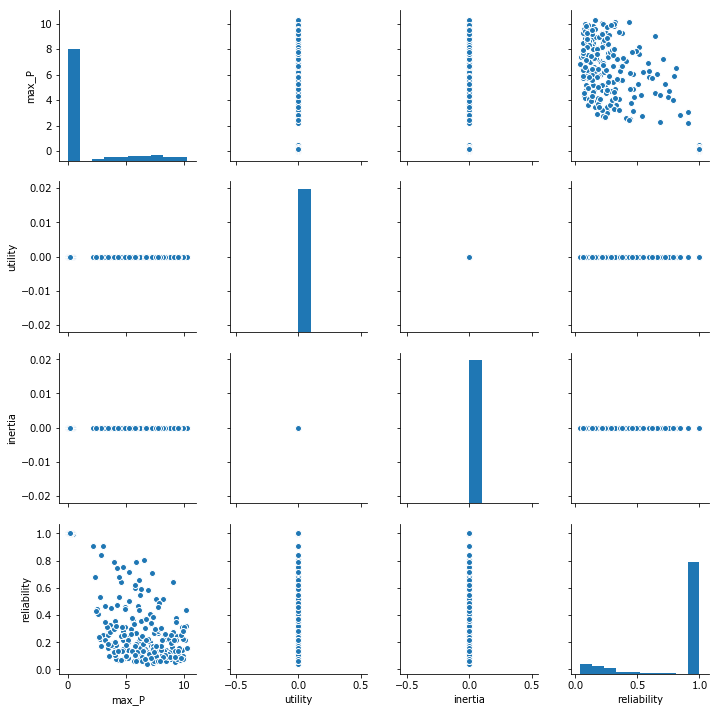

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(outcomes)
data.head()

sns.pairplot(data)
plt.show()

In [8]:
outcomes

{'max_P': array([ 8.55310273,  0.18749748,  0.06749298,  0.04399151,  0.09699158,
         0.11656364,  0.03927614,  0.1288144 ,  0.06853508,  0.13686871,
         6.36112765,  0.24321862,  0.08543559,  0.12370758,  0.15282439,
         0.07262982,  5.05756745,  0.10241251,  0.12910038,  0.09894686,
         0.1438724 ,  0.16263156,  0.10101115,  0.07298379,  0.19520054,
         4.76625004,  0.14646833,  0.07477273,  0.15109335,  0.14964947,
         6.99452546,  6.62873228,  3.81391767,  0.18576142,  0.12130775,
         0.06865007,  4.15484825,  0.07023449,  0.27074668,  0.14387848,
         0.19045554,  4.57855868,  0.09408879,  0.03303118,  0.05443688,
         0.04907668,  0.07603876,  0.1729483 ,  0.12348129, 10.07272397,
         0.13293867,  0.21333853,  4.05354778,  0.07802713,  0.13342708,
         0.08124948,  0.04883715,  9.80287001,  0.12759623,  0.10127706,
         8.79591967,  8.45933061,  0.08409943,  8.58208194,  0.19766073,
         3.86143045,  0.08040328,  0.34288

In [ ]:
#Parallel
#

In [1]:
from __future__ import division

import math
import numpy as np

from scipy.optimize import brentq

def lake_problem(
         b = 0.42,          # decay rate for P in lake (0.42 = irreversible)
         q = 2.0,           # recycling exponent
         mean = 0.02,       # mean of natural inflows
         stdev = 0.0017,     # future utility discount rate
         delta = 0.98,      # standard deviation of natural inflows
         alpha = 0.4,       # utility from pollution
         nsamples = 100,    # Monte Carlo sampling of natural inflows
         steps=100,
         **kwargs):
    #**kwargs - variable arguments - anything that has a name it is a keyword argument (b = 0.42), an argument is just (b)
    #Collect all additional keyword arguments into **kwargs (it is a dictionary keys:values)
    #Can't use integers as a name - in kwargs you can
    #Used for levers
    decisions = [kwargs[str(i)] for i in range(steps)]
    # Decisions: Specify the interface, what parameters go in and what parameters go out the model
    # Match the names of the EMA workbench with the model
    # Difference between uncertainty and level - one you can control and cannot: decision for the modelling maker
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    nvars = len(decisions)
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.array(decisions)
    reliability = 0.0

    for _ in range(nsamples):
        X[0] = 0.0
        
        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)
        
        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] +\
                    natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)
    
        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)
      
    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))
    inertia = np.sum(np.abs(np.diff(decisions)) > 0.02)/float(nvars-1)

    return max_P, utility, inertia, reliability

In [3]:
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome

model = Model('LakeModel', function=lake_problem)

model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('delta', 0.93, 0.99)]

model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

#You make 100 levers and they have a value between 0 and 0.1
#Value given for the steps - each year. Str(i) to correspond to the dictionary steps.
model.levers = [RealParameter(str(i), 0, 0.1) for i in range(100)]

#RealParameter continious steps inbetween - take random steps

#TimeSeries over time
#Scalar one output - does not care about time

C:\Users\newbi\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')


In [4]:
from ema_workbench import SequentialEvaluator, Policy

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100, policies=1)
    
policy = Policy("no release", **{str(i):0 for i in range (100)}) # Policy which sets 0 for every lever
    
#Point in uncertainty space is a scenario
#Point in lever space is a policy
#Workbench will execute a full factorial over the combination of lever and uncertainty

2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


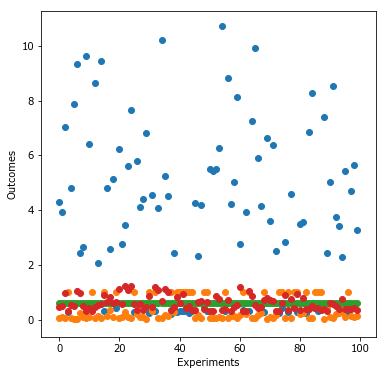

In [47]:
#OLD
import numpy as np
import matplotlib.pyplot as plt

reliability = outcomes["reliability"]
inertia = outcomes["inertia"]
utility = outcomes["utility"]
max_P = outcomes["max_P"]
index = range(len(max_P))

fig, ax = plt.subplots(figsize=(6,6))
sc = ax.scatter(index, max_P)
ax.scatter(index, reliability)
ax.scatter(index, inertia)
ax.scatter(index, utility)
ax.set_xlabel('Experiments')
ax.set_ylabel('Outcomes')
#plt.legend()
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

policies = experiments['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies

C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


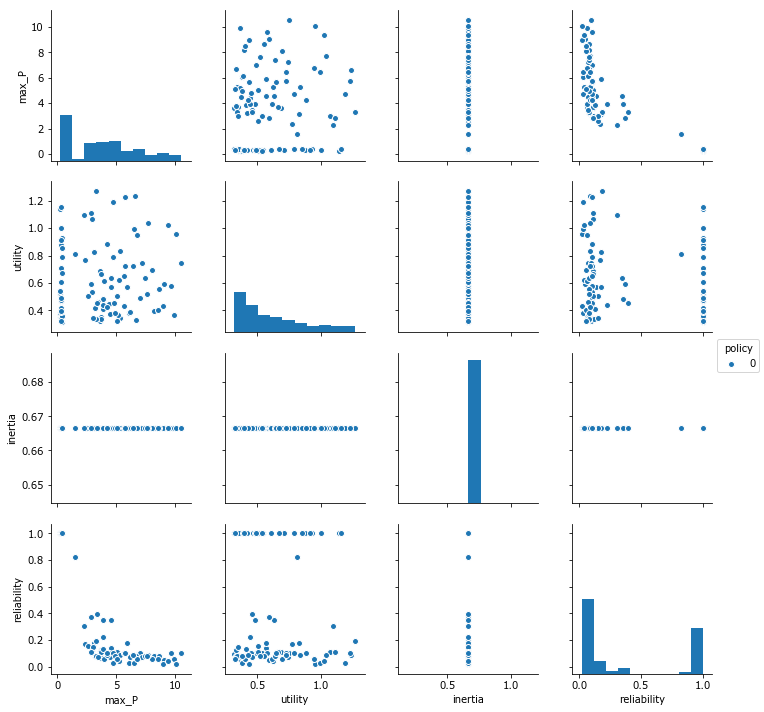

In [9]:
import seaborn as sns

sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

In [48]:
policy1 = Policy("always 0.1", **{str(i):0.1 for i in range (100)})

In [10]:
from ema_workbench import SequentialEvaluator, Policy

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100, policies=3)
    
policy1 = Policy("always 0.1", **{str(i):0.1 for i in range (100)})
policy2 = Policy("always 0.05", **{str(i):0.05 for i in range (100)})
policy3 = Policy("always 0", **{str(i):0 for i in range (100)})

In [11]:
policies = experiments['policy']
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies==policy, 'policy'] = str(i)

data = pd.DataFrame(outcomes)
data['policy'] = policies

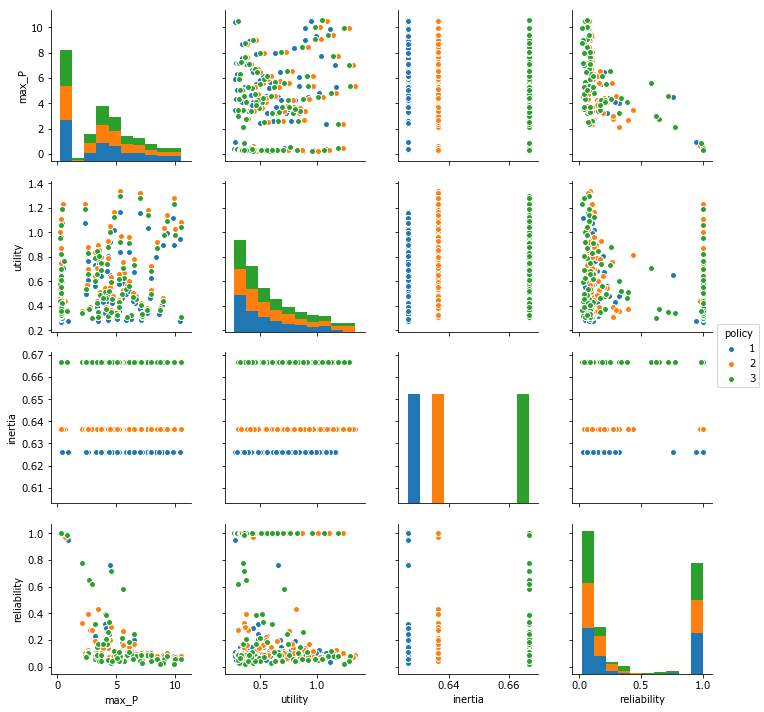

In [12]:
sns.pairplot(data, hue='policy', vars=list(outcomes.keys()))
plt.show()

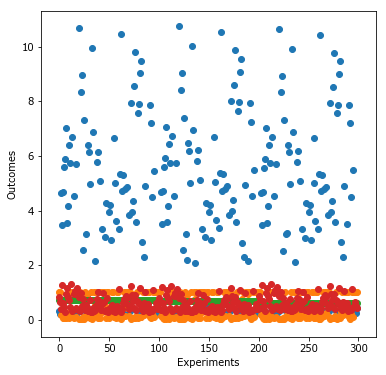

In [52]:
#OLD
import numpy as np
import matplotlib.pyplot as plt

reliability = outcomes["reliability"]
inertia = outcomes["inertia"]
utility = outcomes["utility"]
max_P = outcomes["max_P"]
index = range(len(max_P))

fig, ax = plt.subplots(figsize=(6,6))
sc = ax.scatter(index, max_P)
ax.scatter(index, reliability)
ax.scatter(index, inertia)
ax.scatter(index, utility)
ax.set_xlabel('Experiments')
ax.set_ylabel('Outcomes')
#plt.legend()
plt.show()

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each?
    * for windows users, carefully read [the python documentation](https://docs.python.org/3.6/library/multiprocessing.html). Can you use multiprocessing from within the notebook if the lake_model function is defined within the notebook?

In [4]:
from ema_workbench import MultiprocessingEvaluator, IpyparallelEvaluator
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome

from ema_workbench.examples.lake_model import lake_problem

lake_problem = Model('lakeproblem', function=lake_problem)
 
#specify uncertainties
lake_problem.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
 
# set levers
lake_problem.levers = [RealParameter(str(i), 0, 0.1) for i in range(100)]
 
 
#specify outcomes
lake_problem.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

# Run the experiments
with MultiprocessingEvaluator(lake_problem) as evaluator:
    results = evaluator.perform_experiments(scenarios=10, policies=2)

C:\Users\newbi\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


ImportError: vensim dll not found